In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer=load_breast_cancer()
x=cancer.data
y=cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify=y,test_size=0.2, random_state=42)

In [3]:
#SGDClassifier 클래스를 이영하여 로지스틱 회귀 모델을 훈련
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss='log', random_state=42) #여기서 loss 같이 사용자가 직접 지정해주어야하는 것을, 하이퍼 파라미터라고 부름
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test,y_test)

0.8333333333333334

In [4]:
#서포트 벡터 머신으로 로지스틱 회귀 모델을 훈련하면?
#여기서 서포트 벡터 머신은 '훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업'정도로 이해
sgd2=SGDClassifier(loss='hinge', random_state=42) #hinge가 서포트 벡터머신 문제를 푸는 모델로 바꿔줌
sgd2.fit(x_train_all, y_train_all)
sgd2.score(x_test,y_test)
#모델을 튜닝한다!

0.9385964912280702

In [5]:
#모델을 튜닝할 때 테스트 세트를 안 사용하여 일반화 성능이 왜곡되지 않도록 한다
#모델을 튜닝하는 용도의 세트인 검증세트(개발 세트)를 따로 준비한다
#훈련(60%)검증(20%)테스트(20%)

x_train, x_val, y_train, y_val=train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
#여기서 stratify=y_train_all인 것 주의
print(len(x_train), len(x_val))

364 91


sgd3=SGDClassifier(loss='log', random_state=42) #여기서 loss 같이 사용자가 직접 지정해주어야하는 것을, 하이퍼 파라미터라고 부름
sgd3.fit(x_train, y_train)
sgd3.score(x_val,y_val) # 훈련 세트의 크기가 줄어들었기 때문에 평가 점수가 낮아짐
#데이터의 양이 너무 적은 경우리서 검증세트의 비율이나, random변수를 조금만 수정해도 성능 평가 점수가 큰 폭으로 변화됨
#데이터의 양이 너무 적은 경우는 검증세트를 만들지 않고 '교차검증'이라는 방법을 활용하기도 함
#훈련세트에 압도적으로 많은 샘플을 할당하는 것이 좋음

# 데이터전처리

In [6]:
#준비 되어있는 데이터가 아닌 경우-> 데이터 전처리 필요
#일단 특성의 스케일이 다른 경우에 대해서 살펴보자(특성끼리의 값의 범위가 다르다는 의미)
#경사 하강법은 스케일에 민감한 알고리즘 이므로 특성의 스케일을 맞추는 전처리 필요

['mean perimeter' 'mean area']


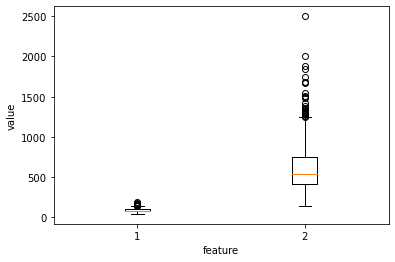

In [7]:
#두 특성의 스케일 비교
import matplotlib.pyplot as plt
import numpy as np
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:,2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [8]:
class SingleLayer:
    def __init__(self, learning_rate=0.1):
        self.w=None
        self.b=None
        self.losses=[] 
        self.w_history=[]# 매 에포크마다 가중치의 값을 저장하여 가중치의 변화를 관찰
        self.lr=learning_rate #학습률(하이퍼 파라미터 중 하나, 가중치의 업데이트 양 조절)
    def forpass(self,x): 
        z=np.sum(x*self.w)+self.b #직선 방정식 계산
        return z
    def backprop(self,x,err):
        w_grad=x*err #가중치에 대한 그레디언트 계산
        b_grad=1*err #절편에 대한 그레디언트 계산
        return w_grad, b_grad
    def activation(self,z):
        a=1/(1+np.exp(-z)) 
        #활성화함수 계산 (로지스틱 회귀는 시그모이드 함수 이용)
        return a
    def fit(self,x,y,epochs=100):
        self.w=np.ones(x.shape[1])
        self.b=0 
        self.w_history.append(self.w.copy())#가중치 기록
        np.random.seed(42)
        for i in range (epochs):
            loss=0
            indexes=np.random.permutation(np.arange(len(x)))
            #매 에포크마다 훈련 세트의 샘플 순서를 섞어서 사용
            #넘파이 배열의 인덱스를 섞은 후 인덱스 순서대로 샘플을 뽑음
            #가중치의 최적값의 탐색 과정이 다양해서 가중치의 최적값을 제대로 찾을 수 있음
            for i in indexes: #모든 샘플에 대하여 반복
                z=self.forpass(x[i]) #정방형 계산
                a=self.activation(z) #활성화 함수 적용
                err=-(y[i]-a) # 오차계산 
                w_grad, b_grad=self.backprop(x[i],err) #역방형 계산
                self.w-=self.lr*w_grad #가중치 업데이트(학습률 적용)
                self.b-=b_grad #절편 업데이트
                self.w_history.append(self.w.copy())
                a=np.clip(a, 1e-10, 1-1e-10) #안전한 로그 계산을 위해서 클리핑 후
                loss+=-(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) # 손실 누적
            self.losses.append(loss/len(y)) #각 에포크마다 평균 손실 계산하여 저장
    def predict(self, x):
        z=[self.forpass(x_i) for x_i in x] #forpass의 결과를 새 리스트로 생성
        #시그모이드 함수의 출력값은 0에서 1사이, z가 양수냐 음수냐에 따라 
        #출력값은 두개로 나뉨, 따라서 굳이 시그모이드 함수의 출력값으로 갈 필요 없음
        return np.array(z)>0
    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [9]:
a=np.array([1,2,3])
lst=[]
lst.append(a)
print(lst) #이런식으로 넘파이 배열을 파이썬 리스트에 append 하면 참조로 들어감
lst.append(a.copy())
print(lst)

[array([1, 2, 3])]
[array([1, 2, 3]), array([1, 2, 3])]


In [10]:
layer1=SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val,y_val)

<ipython-input-8-e3d9bf994761>:16: RuntimeWarning: overflow encountered in exp
  a=1/(1+np.exp(-z))


0.9120879120879121

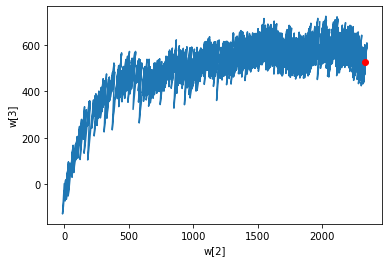

In [11]:
w2=[]
w3=[]
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
#w[3]의 mean area의 스케일이 너무 커서 w3의 학습 과정에서 가중치가 큰 폭으로 흔들리며 변화하고 있음을 확인할 수 있음
#'w3에 대한 그레이디언트가 크기 때문에 w3 축을 따라 가중치가 크게 요동치고 있다'
#스케일을 조정해 모델이 최종 가중치에 안정적으로 수렴할 수 있게끔 해야 한다.

In [12]:
#대표적인 스케일 조정 : 표준화 -> 사이킷런에 StandardSclar 클래스로 구현이 되어있음
#먼저, 넘파이로 표준화 구현하기
train_mean=np.mean(x_train, axis=0) #axis=0 은 2차원 배열의 열을 기준으로 통계치를 계산하여 하나의 행벡터로 변환해줌
train_std=np.std(x_train, axis=0)
x_train_scaled=(x_train-train_mean)/train_std

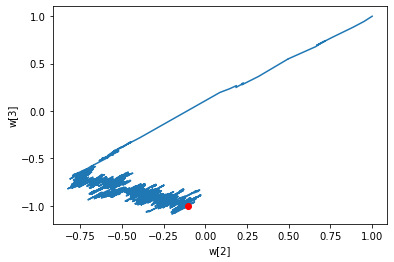

In [13]:
layer2=SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2=[]
w3=[]
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show() #두 변화 비율이 비슷하기 때문에 대각선 방향으로 가중치 이동, 최적값에 빠르게 근접

In [14]:
layer2.score(x_val,y_val) #검증세트는 전처리가 안되어 있기 때문에 성능이 좋지 않음

0.37362637362637363

In [15]:
val_mean=np.mean(x_val, axis=0) #axis=0 은 2차원 배열의 열을 기준으로 통계치를 계산하여 하나의 행벡터로 변환해줌
val_std=np.std(x_val, axis=0)
x_val_scaled=(x_val-val_mean)/val_std
layer2.score(x_val_scaled,y_val)

0.967032967032967

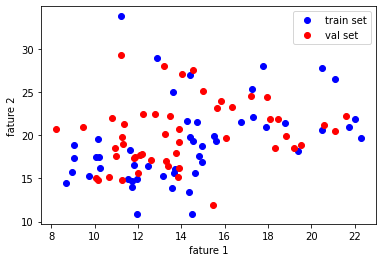

In [16]:
#스케일을 조정한 후, 실수하기 쉬운 함정 -> '훈련세트와 검증 세트가 다른 비율로 스케일이 조정된 경우'
plt.plot(x_train[:50, 0], x_train[:50,1],'bo')
plt.plot(x_val[:50, 0], x_val[:50,1],'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show()
#파란점이 훈련세트, 빨간점이 검증 세트, 산점도 그리기 -> 전처리 전

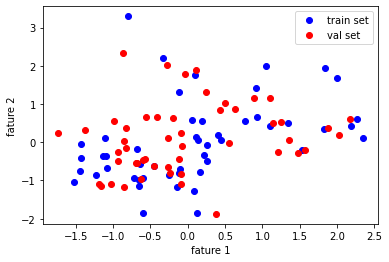

In [17]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1],'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show() #원본 훈련 세트와 검증세트의 점과 점 사이의 거리가 변환된 이후에 그대로 유지되지 않았음 
#-> 훈련세트와 검증세트를 각각 다른 비율로 전처리 했기 때문

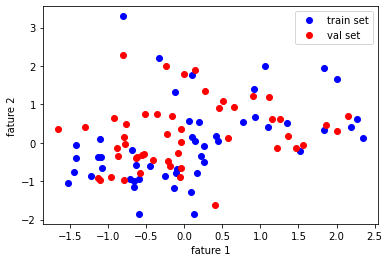

In [18]:
#같은 비율로 검증세트를 변환하기 위해서는 훈련세트의 평균과 표준편차를 사용하여, 검증세트를 변환하면 된다
x_val_scaled=(x_val-train_mean)/train_std

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1],'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show() #산점도가 원본데이터와 스케일 조정 이후가 같게 나타남

In [19]:
layer2.score(x_val_scaled,y_val) #데이터 세트가 크지가 않아 성능의 변화는 없음 (크기가 커지면 성능의 차이가 나타날 수 있음)

0.967032967032967

# 과대적합과 과소적합

In [20]:
class SingleLayer:
    def __init__(self, learning_rate=0.1):
        self.w=None
        self.b=None
        self.losses=[] 
        self.val_losses=[]
        self.w_history=[]# 매 에포크마다 가중치의 값을 저장하여 가중치의 변화를 관찰
        self.lr=learning_rate #학습률(하이퍼 파라미터 중 하나, 가중치의 업데이트 양 조절)
    def forpass(self,x): 
        z=np.sum(x*self.w)+self.b #직선 방정식 계산
        return z
    def backprop(self,x,err):
        w_grad=x*err #가중치에 대한 그레디언트 계산
        b_grad=1*err #절편에 대한 그레디언트 계산
        return w_grad, b_grad
    def activation(self,z):
        a=1/(1+np.exp(-z)) 
        #활성화함수 계산 (로지스틱 회귀는 시그모이드 함수 이용)
        return a
    def fit(self,x,y,epochs=100,x_val=None, y_val=None):
        self.w=np.ones(x.shape[1])
        self.b=0 
        self.w_history.append(self.w.copy())#가중치 기록
        np.random.seed(42)
        for i in range (epochs):
            loss=0
            indexes=np.random.permutation(np.arange(len(x)))
            #매 에포크마다 훈련 세트의 샘플 순서를 섞어서 사용
            #넘파이 배열의 인덱스를 섞은 후 인덱스 순서대로 샘플을 뽑음
            #가중치의 최적값의 탐색 과정이 다양해서 가중치의 최적값을 제대로 찾을 수 있음
            for i in indexes: #모든 샘플에 대하여 반복
                z=self.forpass(x[i]) #정방형 계산
                a=self.activation(z) #활성화 함수 적용
                err=-(y[i]-a) # 오차계산 
                w_grad, b_grad=self.backprop(x[i],err) #역방형 계산
                self.w-=self.lr*w_grad #가중치 업데이트(학습률 적용)
                self.b-=b_grad #절편 업데이트
                self.w_history.append(self.w.copy())
                a=np.clip(a, 1e-10, 1-1e-10) #안전한 로그 계산을 위해서 클리핑 후
                loss+=-(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) # 손실 누적
            self.losses.append(loss/len(y)) #각 에포크마다 평균 손실 계산하여 저장
            self.update_val_loss(x_val,y_val)#검증세트에 대한 손실을 계산
    def update_val_loss(self,x_val, y_val):
        if x_val is None:
            return 
        val_loss=0
        for i in range(len(x_val)):
            z=self.forpass(x_val[i]) #정방형 계산
            a=self.activation(z)
            a=np.clip(a, 1e-10, 1-1e-10)
            val_loss+=-(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val))
    def predict(self, x):
        z=[self.forpass(x_i) for x_i in x] #forpass의 결과를 새 리스트로 생성
        #시그모이드 함수의 출력값은 0에서 1사이, z가 양수냐 음수냐에 따라 
        #출력값은 두개로 나뉨, 따라서 굳이 시그모이드 함수의 출력값으로 갈 필요 없음
        return np.array(z)>0
    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [21]:
layer3=SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

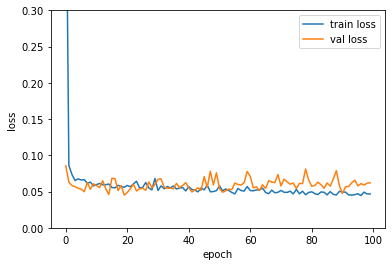

In [22]:
plt.ylim(0,0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()#검증 손실이 대략 20번째 에포크 이후에 훈련세트보다 높아지는 것을 알 수 있음
#에포크가 진행됨에 따라 가중치는 훈련 세트에 잘 맞게 되지만 검증 세트에는 잘 맞지 않게 됨. 20번째 이후의 에포크는 훈련필요없음

In [23]:
#훈련 조기 종료
layer4=SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20) #early stopping
layer4.score(x_val_scaled,y_val)

0.978021978021978

# 규제

In [27]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [28]:
 class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):       
        self.w=None
        self.b=None
        self.losses=[] 
        self.val_losses=[]
        self.w_history=[]# 매 에포크마다 가중치의 값을 저장하여 가중치의 변화를 관찰
        self.lr=learning_rate #학습률(하이퍼 파라미터 중 하나, 가중치의 업데이트 양 조절)
        self.l1=l1
        self.l2=l2
    def forpass(self,x): 
        z=np.sum(x*self.w)+self.b #직선 방정식 계산
        return z
    def backprop(self,x,err):
        w_grad=x*err #가중치에 대한 그레디언트 계산
        b_grad=1*err #절편에 대한 그레디언트 계산
        return w_grad, b_grad
    def activation(self,z):
        a=1/(1+np.exp(-z)) 
        #활성화함수 계산 (로지스틱 회귀는 시그모이드 함수 이용)
        return a
    def fit(self,x,y,epochs=100,x_val=None, y_val=None):
        self.w=np.ones(x.shape[1])
        self.b=0 
        self.w_history.append(self.w.copy())#가중치 기록
        np.random.seed(42)
        for i in range (epochs):
            loss=0
            indexes=np.random.permutation(np.arange(len(x)))
            #매 에포크마다 훈련 세트의 샘플 순서를 섞어서 사용
            #넘파이 배열의 인덱스를 섞은 후 인덱스 순서대로 샘플을 뽑음
            #가중치의 최적값의 탐색 과정이 다양해서 가중치의 최적값을 제대로 찾을 수 있음
            for i in indexes: #모든 샘플에 대하여 반복
                z=self.forpass(x[i]) #정방형 계산
                a=self.activation(z) #활성화 함수 적용
                err=-(y[i]-a) # 오차계산 
                w_grad, b_grad=self.backprop(x[i],err) #역방형 계산
                w_grad+=self.l1*np.sign(self.w)+self.l2*self.w
                self.w-=self.lr*w_grad #가중치 업데이트(학습률 적용)
                self.b-=b_grad #절편 업데이트
                self.w_history.append(self.w.copy())
                a=np.clip(a, 1e-10, 1-1e-10) #안전한 로그 계산을 위해서 클리핑 후
                loss+=-(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) # 손실 누적
            self.losses.append(loss/len(y)) #각 에포크마다 평균 손실 계산하여 저장
            self.update_val_loss(x_val,y_val)#검증세트에 대한 손실을 계산
    def update_val_loss(self,x_val, y_val):
        if x_val is None:
            return 
        val_loss=0
        for i in range(len(x_val)):
            z=self.forpass(x_val[i]) #정방형 계산
            a=self.activation(z)
            a=np.clip(a, 1e-10, 1-1e-10)
            val_loss+=-(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val)+self.reg_loss())
    def reg_loss(self):
        return self.l1*np.sum(np.abs(self.w))+self.l2/2*np.sum(self.w**2)
    def predict(self, x):
        z=[self.forpass(x_i) for x_i in x] #forpass의 결과를 새 리스트로 생성
        #시그모이드 함수의 출력값은 0에서 1사이, z가 양수냐 음수냐에 따라 
        #출력값은 두개로 나뉨, 따라서 굳이 시그모이드 함수의 출력값으로 갈 필요 없음
        return np.array(z)>0
    def score(self, x, y):
        return np.mean(self.predict(x)==y)

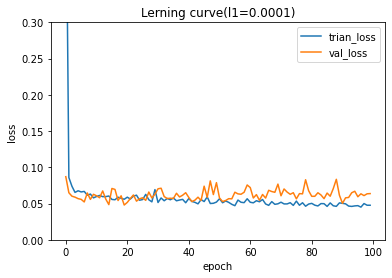

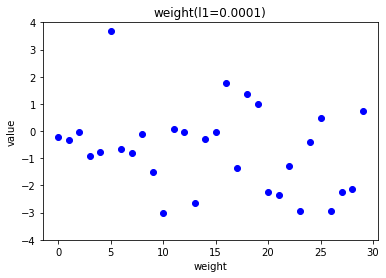

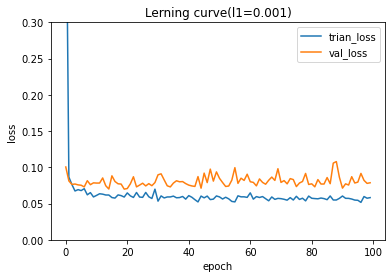

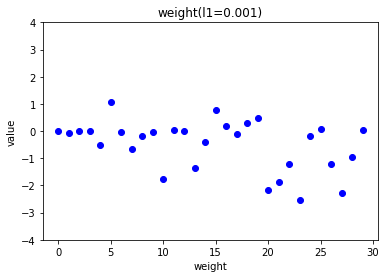

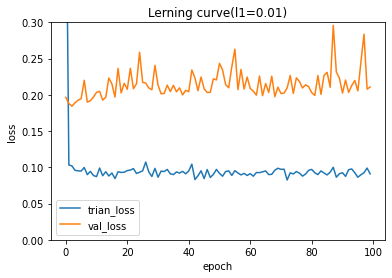

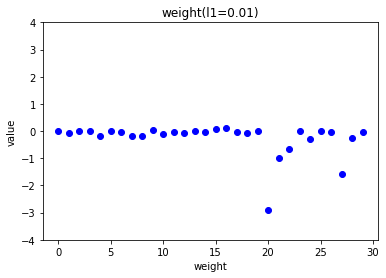

In [38]:
l1_list=[0.0001,0.001,0.01]

for l1 in l1_list:
    lyr=SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train,x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Lerning curve(l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['trian_loss', 'val_loss'])
    plt.ylim(0,0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('weight(l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4,4)
    plt.show()
#규제가커질수록 훈련세트의 손실과 검증세트의 손실이 높아진다->과소적합 현상이 나타난다   

In [39]:
#l1의 적당한 규제강도를 가지는 하이퍼파라미터의 값은 0.001 정도이다
#성능평가 -> 데이터 세트가 작아서 규제 효과가 크게 나타나지 않는다
layer5=SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20) #early stopping
layer5.score(x_val_scaled,y_val)

0.978021978021978

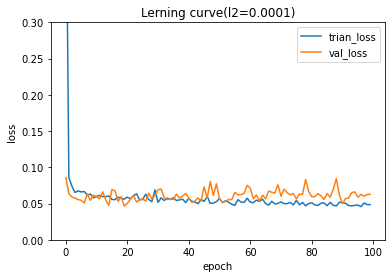

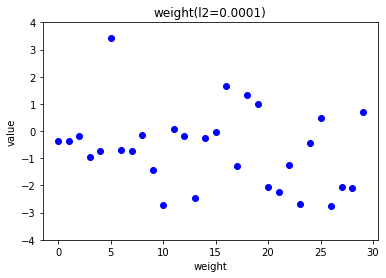

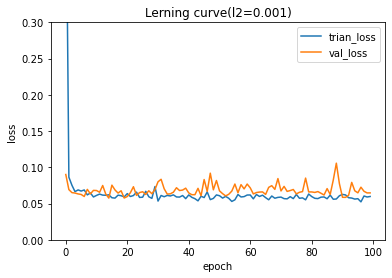

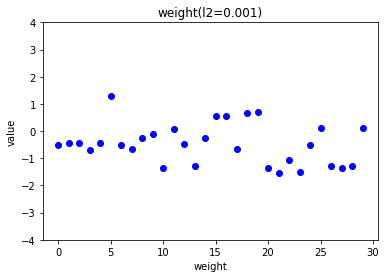

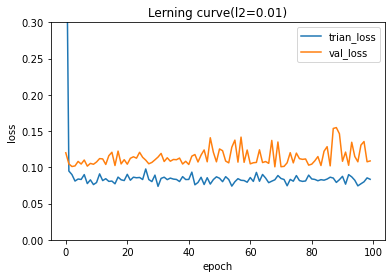

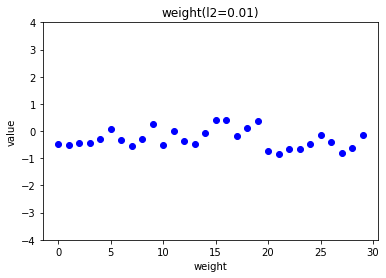

In [40]:
l2_list=[0.0001,0.001,0.01]

for l2 in l2_list:
    lyr=SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train,x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Lerning curve(l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['trian_loss', 'val_loss'])
    plt.ylim(0,0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('weight(l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4,4)
    plt.show()

In [44]:
layer6=SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50) 
#가중치를 강하게 제한 했기 때문에 검증세트의 손실값을 일정한 수준으로 유지하면서 
#알고리즘이 전역 최솟값을 찾는과정을 오래 반복할 수 있었던것
layer6.score(x_val_scaled,y_val)

0.978021978021978

In [43]:
np.sum(layer6.predict(x_val_scaled)==y_val)

89

In [48]:
sgd=SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42) 
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled,y_val)

0.978021978021978

# K-fold 교차검증

In [47]:
#각 폴드의 검증 점수를저장하기 위한 validation_score[]
validation_scores=[]

In [58]:
k=10
bins=len(x_train)//k

for i in range(k):
    start=i*bins
    end=(i+1)*bins
    val_fold=x_train_all[start:end]
    val_target=y_train_all[start:end]
    
    train_index=list(range(0,start))+list(range(end,len(x_train)))
    train_fold=x_train_all[train_index]
    train_target=y_train_all[train_index]
    
    train_mean=np.mean(train_fold,axis=0)
    train_std=np.std(train_fold,axis=0)
    train_fold_scaled=(train_fold-train_mean)/train_std
    val_fold_scaled=(val_fold-train_mean)/train_std
    
    lyr=SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score=lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)
    
print(np.mean(validation_scores))

0.9583333333333333


In [62]:
from sklearn.model_selection import cross_validate
sgd=SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42) 
scores=cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score'])) #전처리 안해서 점수낮음

0.850096618357488


In [68]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe=make_pipeline(StandardScaler(),sgd)
scores=cross_validate(pipe,x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [69]:
print(np.mean(scores['train_score']))

0.9875478561631581
